# Demo for DoWhy Causal Prediction on MNIST

We're adding prediction functionality to DoWhy. The goal of this notebook is to demonstrate an example of causal prediction using *Causally Adaptive Constraint Minimization (CACM)* [1]. 

[1] Kaur, J.N., Kıcıman, E., & Sharma, A. (2022). Modeling the Data-Generating Process is Necessary for Out-of-Distribution Generalization. ArXiv, abs/2206.07837.

## Multi-attribute distribution shift datasets 

Domain generalization literature has largely focused on datasets with a single kind of distribution shift over one attribute. Using MNIST as an example, domains are created either by adding new values of a spurious attribute like rotation (e.g., Rotated-MNIST dataset [2]) or domains exhibit different values of correlation between the class label and a spurious attribute like color (e.g., Colored-MNIST [3]). However, real-world data often has multiple distribution shifts over different attributes. For example, satellite imagery data demonstrates distribution shifts over time as well as the region captured.

[2] Ghifary, M., Kleijn, W., Zhang, M., & Balduzzi, D. (2015). Domain Generalization for Object Recognition with Multi-task Autoencoders. 2015 IEEE International Conference on Computer Vision (ICCV), 2551-2559.<br>
[3] Arjovsky, M., Bottou, L., Gulrajani, I., & Lopez-Paz, D. (2019). Invariant Risk Minimization. ArXiv, abs/1907.02893.


### Multi-attribute MNIST

We create a *multi-attribute* shift variant of MNIST, where both the color and rotation angle of digits can shift across data distributions. Hence, we create three variants of MNIST -- `MNISTCausalAttribute` (single-attribute shift), `MNISTIndAttribute` (single-attribute shift), `MNISTCausalIndAttribute` (multi-attribute shift). To describe, `Causal`, `Ind`, and `CausalInd` datasets better, consider the causal graph for the data generating process below:



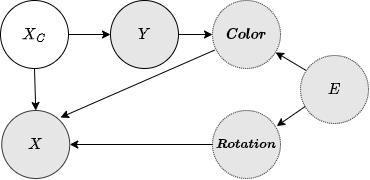

Distribution shifts are characterized based on the relationship between spurious attributes ***A*** and the classification label *Y*.
1. `Causal`: Attribute has a direct-*Causal* relationship with the class label i.e., *Y* causing attribute (e.g., *Color* here)
2. `Ind`: Attribute is *Independent* of the class label (e.g., *Rotation* here)
3. `CausalInd`: Different attributes having *Causal* and *Independent* relationships with *Y* co-exist in the data

### Domains in multi-attribute MNIST

We describe the domains for our *multi-attribute* shift dataset `MNISTCausalIndAttribute`.<br> 
Each domain E<sub>i</sub> has a specific *Rotation* angle r<sub>i</sub> and a specific correlation corr<sub>i</sub> between *Color C* and label *Y* . Our setup consists of 3 domains:
E<sub>1</sub>, E<sub>2</sub> are training domains, E<sub>3</sub> is the test domain. We define corr<sub>i</sub> = P(*Y* = 1|*C* = 1) = P(*Y* = 0|*C* = 0) in E<sub>i</sub>. In our setup, r<sub>1</sub> = 15◦, r<sub>2</sub> = 60◦, r<sub>3</sub> = 90◦ and corr<sub>1</sub> = 0.9, corr<sub>2</sub> = 0.8, corr<sub>3</sub> = 0.1. All environments have 25% label noise, as in [3]


Other dataset-related details can be found in `dowhy.causal_prediction.datasets`.

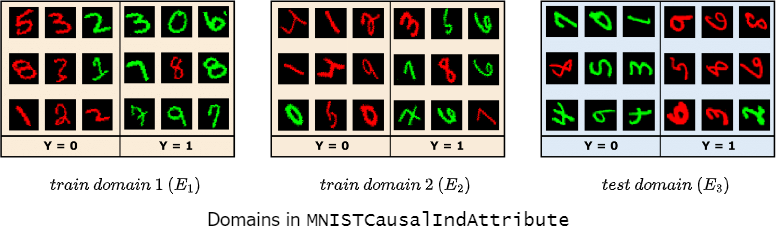

In [ ]:
import torch
import pytorch_lightning as pl

## Initialize dataset

In [ ]:
from dowhy.causal_prediction.datasets.mnist import MNISTCausalAttribute

# dataset class initialization requires mandatory param `data_dir`
# `download` is passed to torchvision.datasets.MNIST and downloads data if not present 
data_dir = 'data'
dataset = MNISTCausalAttribute(data_dir, download=True)

## Initialize data loaders

`get_loaders` returns data loaders for training, validation, and test. `loaders` returned is a dictionary of `train_loaders`, `val_loaders`, `test_loaders`. There are two scenarios supported currently to initialize validation domains:

**Method 1**: When a domain(s) from the dataset is explicitly specified as the validation domain <br>
**Method 2**: When no specific validation domain is present, a subset of the training domain(s) is used to create the validation set

Run either cell below Method 1 or Method 2 as required.

In [ ]:
from dowhy.causal_prediction.dataloaders.get_data_loader import get_loaders

### Method 1: Provide validation domain explicitly
Provide index of validation domains as `val_envs`. `test_envs` is an optional parameter.

In [ ]:
loaders = get_loaders(dataset, train_envs=[0, 1], batch_size=64,
            val_envs=[2], test_envs=[3])

### Method 2: Validation set using subset of training data

`val_envs`, `test_envs` are optional parameters. If `val_envs` is not provided, a subset of training data is used for creating the validation set. The fraction of training data used is determined by `holdout_fraction`.

In [ ]:
loaders = get_loaders(dataset, train_envs=[0, 1], batch_size=64,
            holdout_fraction=0.2, test_envs=[3])

The code below handles more than one validation or test domains, if present. Run the cell below irrespective of Method 1 or 2 used above.

In [ ]:
# handle multiple validation and test domains if present 
from pytorch_lightning.trainer.supporters import CombinedLoader

if len(loaders['val_loaders']) > 1:
    val_loaders = loaders['val_loaders']
    loaders['val_loaders'] = CombinedLoader(val_loaders)
    
if len(loaders['test_loaders']) > 1:
    test_loaders = loaders['test_loaders']
    loaders['test_loaders'] = CombinedLoader(test_loaders)

## Initialize model and algorithm 

In [ ]:
from dowhy.causal_prediction.models.networks import MNIST_MLP, Classifier

`model` below is expected to be of type `torch.nn.Sequential` with two `torch.nn.Module` elements (feature extractor and classifier). We provide sample networks (MLP, ResNet) in `dowhy.causal_prediction.models.networks` but the user can flexibly use any model.


In [ ]:
featurizer = MNIST_MLP(dataset.input_shape)
classifier = Classifier(
    featurizer.n_outputs,
    dataset.num_classes)

model = torch.nn.Sequential(featurizer, classifier)

### Initialize algorithm class: ERM

In [ ]:
from dowhy.causal_prediction.algorithms.erm import ERM

In [ ]:
algorithm = ERM(model, lr=1e-3)

## Fit predictor and start training

Note: The optimal accuracy for `MNISTCausalAttribute` (and other MNIST variants introduced) is **75%** as we introduce 25% noise following previous work.

In [ ]:
trainer = pl.Trainer(devices=1, max_epochs=5) 

# val_loaders is optional param
trainer.fit(algorithm, loaders['train_loaders'], loaders['val_loaders'])

## Evaluate on test domain

Perform an evaluation epoch over the test set using `trainer.test`. `ckpt_path` determines the model to be used for evaluation -- 'best', 'last', or path to a specific checkpoint. If `ckpt_path` is not passed, best model checkpoint from the previous `trainer.fit` is loaded (https://pytorch-lightning.readthedocs.io/en/stable/_modules/pytorch_lightning/trainer/trainer.html#Trainer.test).

We report accuracy (`test_acc`) and cross-entropy loss (`test_loss`) on the test domains/test set.

In [ ]:
if 'test_loaders' in loaders:
    trainer.test(dataloaders=loaders['test_loaders'], ckpt_path='best')

## Prediction with CACM

We now train and evaluate the above dataset with CACM. We specify the type of shifts present using list `attr_types` provided as input to CACM. Further instructions regarding using CACM with multi-attribute shifts is provided in the next section.

In [ ]:
from dowhy.causal_prediction.algorithms.cacm import CACM

In [ ]:
# `attr_types` list contains type of attributes present (supports 'causal' and 'ind' currently)
algorithm = CACM(model, lr=1e-3, gamma=1e-2, attr_types=['causal'], lambda_causal=100.)

In [ ]:
trainer = pl.Trainer(devices=1, max_epochs=5) 

trainer.fit(algorithm, loaders['train_loaders'], loaders['val_loaders'])

In [ ]:
if 'test_loaders' in loaders:
    trainer.test(dataloaders=loaders['test_loaders'], ckpt_path='best')

## Extending to different datasets and algorithms

### MNIST Independent and Causal+Independent datasets

We show how to perform the above evaluation for `MNISTIndAttribute` and`MNISTCausalIndAttribute` datasets. Additional `attr_types` should be provided to CACM algorithm for handling multiple shifts. We currently support `Causal` and `Independent` distribution shifts in the data.

#### `MNISTIndAttribute`: Single-attribute *Independent* shift

In [ ]:
from dowhy.causal_prediction.datasets.mnist import MNISTIndAttribute

data_dir = 'data'
dataset = MNISTIndAttribute(data_dir)

In [ ]:
algorithm = CACM(model, lr=1e-3, gamma=1e-2, attr_types=['ind'], lambda_ind=10.)

#### `MNISTCausalIndAttribute`: Multi-attribute *Causal*+*Independent* shift

In [ ]:
from dowhy.causal_prediction.datasets.mnist import MNISTCausalIndAttribute

data_dir = 'data'
dataset = MNISTCausalIndAttribute(data_dir)

In [ ]:
# `attr_types` can be provided in any order
algorithm = CACM(model, lr=1e-3, gamma=1e-2, attr_types=['ind', 'causal'], lambda_causal=100., lambda_ind=10.)

### Additional datasets and algorithms

We provide our demo on MNIST using ERM and *CACM* algorithms. It is possible to extend the evaluation to new datasets and algorithms for evaluation.


New datasets can be added to `dowhy.causal_prediction.datasets` and imported here, as we did for MNIST. We provide description of the MNIST dataset (and variants) in `dowhy.causal_prediction.datasets.mnist` that will be helpful in creating new dataset classes. We currently support `Causal` and `Independent` distribution shifts in the data.

We have implemented ERM in `dowhy.causal_prediction.algorithms` as a baseline. Additional algorithms can be added by overriding the `training_step` function in base class `PredictionAlgorithm`.